In [38]:
import os
import json
import glob
import pandas as pd
import numpy as np
from google.colab import files

In [2]:
RUN_ENV = 'COLAB' # 'PC' or 'COLAB'

# 0 Load Data by uploading json files maded by ning (need to repeat every time b4 u start)

In [73]:
if RUN_ENV == 'COLAB':
    #json文件，地址在github库MF_KOC\Data\raw\, 导入上传文件为data frame格式
    uploaded_creator = files.upload()
    df_creator_0 = pd.read_json(next(iter(uploaded_creator)))
    df_creator = df_creator_0.copy()
    uploaded_content = files.upload()
    df_contents_0 = pd.read_json(next(iter(uploaded_content)))
    df_contents = df_contents_0.copy()
elif RUN_ENV == 'PC':
    #读取本地json文件
    df_creator = pd.read_json(r'..\Data\raw\creator_cooked.json')
    df_contents = pd.read_json(r'..\Data\raw\contents_cooked.json')

Saving creator_cooked.json to creator_cooked (3).json


Saving contents_cooked.json to contents_cooked (3).json


In [75]:
df_creator.shape

(102, 45)

In [76]:
df_contents.shape

(15941, 16)

In [77]:
df_creator.head(1).T

,0
user_id,576d3bde82ec3952ff40c5e1
nickname,达拉斯小鸡腿
avatar,https://sns-avatar-qc.xhscdn.com/avatar/61df4c...
desc,慢慢了解世界，慢慢更新自己\n吃喝玩乐+宝宝们，随心分享\n佛系更新中～比心🫰 | Zodi...
ip_location,美国
follows,837
fans,1653
interaction,11636
last_modify_ts,1741740734045
pic_per_normal_note,7.583333


In [78]:
df_contents.head(1).T

,0
note_id,67d0d605000000002903d86a
user_id,576d3bde82ec3952ff40c5e1
title,有没有和我一样【吃茶三千】一喝一个不吱声的
note_body,连地址都不想写了[笑哭R]\n虽然环境还不错，颜值也不错\n但我感觉自己完全拔草了\n尝了m...
tag_list,"达拉斯网红奶茶,达拉斯奶茶,达拉斯,达拉斯生活,达拉斯美食,达拉斯周边,达拉斯探店"
image_count,1
content_type_video,0
hot_note,0
post_time,2025-03-12 00:32:05
last_update_time,2025-03-12 00:32:06


# 2 Treat the df_contents table

In [79]:
import numpy as np
import pandas as pd
import math

# =====================
# 互动效能 Interaction Efficiency (50%)
# =====================

import numpy as np

def calculate_interaction_efficiency(df_contents, user_id):
    """
    计算互动效能得分 (50%)
    根据时间衰减的点赞、收藏、评论量进行加权，基于更高分位值（例如90%分位）来避免轻易满分。
    衰减系数通过计算发帖时间与当前时间的差异，减少老帖的影响。

    衰减公式：
    d_i = exp(-0.0077 * t)  (t = 发帖到抓取的天数)

    采用 logistic 映射函数避免容易获得满分。
    打分公式计算的是每个互动类型的加权得分，并结合权重进行总得分的计算。

    参数：
    df_contents: 包含内容数据（例如点赞数、评论数等）的 DataFrame
    user_id: 需要计算互动效能得分的用户ID

    返回：
    互动效能得分，范围 0 到 50
    """

    current_content = df_contents[df_contents['user_id'] == user_id].copy()

    if current_content.empty:
        return 0.0

    # 计算动态基准值：点赞、收藏、评论的90%分位值（提高标准）
    B_L = np.percentile(df_contents['liked_count'], 90)    # 点赞基准
    B_CL = np.percentile(df_contents['collected_count'], 90)  # 收藏基准
    B_C = np.percentile(df_contents['comment_count'], 90)   # 评论基准

    # 计算时间衰减
    current_content['days_since_post'] = (current_content['scraped_time'] - current_content['post_time']).dt.days.clip(lower=0)
    current_content['decay'] = np.exp(-0.0077 * current_content['days_since_post'])

    # 计算加权后的互动量
    like_weighted = (current_content['liked_count'] * current_content['decay']).sum()
    collect_weighted = (current_content['collected_count'] * current_content['decay']).sum()
    comment_weighted = (current_content['comment_count'] * current_content['decay']).sum()

    # 使用 logistic 映射函数来避免得分过高
    def logistic_map(x, base, scale=0.1):
        return 1 / (1 + np.exp(-scale * (x - base)))

    # 计算每个互动类型的得分
    like_score = logistic_map(like_weighted, B_L) * 0.35
    collect_score = logistic_map(collect_weighted, B_CL) * 0.45
    comment_score = logistic_map(comment_weighted, B_C) * 0.2

    # 计算最终的互动效能得分，按50%权重计算
    total_score = (like_score + collect_score + comment_score) * 50
    return min(total_score, 50)  # 保证最终得分不超过50



# =====================
# 互动质量 Interaction Quality (30%)
# =====================

def calculate_interaction_quality(df_creator, df_contents, user_id):
    """
    计算互动质量得分 (30%)，使用 logistic 映射函数提升分布平滑性与可区分性。
    """

    user = df_creator[df_creator['user_id'] == user_id]
    if user.empty:
        return 0.0
    user = user.iloc[0]

    fans = user['fans']
    notes = df_contents[df_contents['user_id'] == user_id]
    total_likes = notes['liked_count'].sum()
    total_collects = notes['collected_count'].sum()
    total_comments = notes['comment_count'].sum()
    total_interactions = total_likes + total_collects + total_comments

    if fans == 0 or total_interactions == 0:
        return 0.0

    # 基准值
    B_Int = 25   # 渗透率基准
    B_AF = 50    # 活跃粉丝占比
    B_CR = 10    # 评论占比

    # 计算原始指标
    penetration = total_interactions / fans * 100
    comment_ratio = total_comments / total_interactions * 100
    active_fan_ratio = 50  # 默认占比

    # logistic 映射函数（可调节 center 和 slope）
    def logistic_map(x, center, scale=0.2):
        return 1 / (1 + np.exp(-scale * (x - center)))

    if fans >= 1000:
        p_score = logistic_map(penetration, B_Int)
        a_score = logistic_map(active_fan_ratio, B_AF)
    else:
        p_score = logistic_map(penetration, B_Int)
        a_score = logistic_map(comment_ratio, B_CR)

    final_score = (p_score * 0.7 + a_score * 0.3) * 30
    return round(min(final_score, 30), 4)


# =====================
# 账号活跃度 Account Activity (20%)
# =====================

def calculate_account_activity(df_contents, user_id, now=None):
    """
    计算账号活跃度得分（占总分 20%）
    根据发帖间隔、发帖波动性（标准差）、近90天发帖数量来评估活跃度。
    通过软化公式，避免极端得分，给中等活跃度的用户适当加分。

    评分维度：
    - 发帖间隔均值：频繁发帖用户得分更高
    - 发帖波动性（标准差）：发帖越规律得分越高
    - 近90天发帖数量：越活跃得分越高

    参数：
    df_contents: 包含内容数据（例如发帖时间）的 DataFrame
    user_id: 需要计算活跃度得分的用户ID
    now: 当前时间，默认为当前时间（用于计算近90天发帖）

    返回：
    账号活跃度得分，范围 0 到 20
    """

    if now is None:
        now = pd.Timestamp.now()

    # 获取该用户的所有发帖记录，并按时间排序
    notes = df_contents[df_contents['user_id'] == user_id].sort_values('post_time')

    # 若帖子少于2条，无法计算间隔和标准差，直接返回0分
    if notes.empty or len(notes) < 2:
        return 0.0

    # 计算发帖间隔和标准差（单位：天）
    post_times = notes['post_time']
    intervals = post_times.diff().dropna().dt.days
    avg_gap = intervals.mean()
    std_gap = intervals.std()

    # 近90天发帖数量
    recent_count = notes[notes['post_time'] >= now - pd.Timedelta(days=90)].shape[0]

    # ----------- 各项评分逻辑 -----------

    # 发帖间隔评分：
    # 平均间隔 ≤7天 得满分6分，超过的每1天扣1分
    score_gap = max(0, min(6, 6 - (avg_gap - 7))) if avg_gap else 6

    # 发帖规律性评分（标准差）：
    # 标准差≤2天得满分2分，超过的部分每增加1天扣0.3分
    score_std = max(0, 2 - 0.25 * max(0, std_gap - 2))

    # 近90天活跃度评分：
    # 发帖数≥16得满分8分，每2篇帖子得1分
    score_recent = max(0, min(8, recent_count / 2))

    # 汇总总分，加权系数提升总分表现，再封顶20分
    total_score = (score_gap + score_std + score_recent) * 1.2
    return round(min(total_score, 20), 2)  # 保证最终得分不超过20


# =====================
# 汇总所有得分并加入 df_creator
# =====================

def add_final_score_to_df_creator(df_creator, df_contents):
    """
    为 df_creator 添加维度1互动类评分：
    - score1a_efficiency: 互动效能得分（最多50）
    - score1b_quality: 互动质量得分（最多30）
    - score1c_activity: 活跃度得分（最多20）
    - score1_account_influence: 综合账号影响力得分（最多100）

    不导出JSON，只更新DataFrame。
    """

    score1_eff, score1_qual, score1_act, score1_total = [], [], [], []

    for _, row in df_creator.iterrows():
        uid = row['user_id']

        # 计算各项得分
        s_eff = calculate_interaction_efficiency(df_contents, uid)
        s_qual = calculate_interaction_quality(df_creator, df_contents, uid)
        s_act = calculate_account_activity(df_contents, uid)
        s_total = s_eff + s_qual + s_act

        # 添加至列表
        score1_eff.append(s_eff)
        score1_qual.append(s_qual)
        score1_act.append(s_act)
        score1_total.append(s_total)

    # 更新 DataFrame 列
    df_creator['score1a_efficiency'] = score1_eff
    df_creator['score1b_quality'] = score1_qual
    df_creator['score1c_activity'] = score1_act
    df_creator['score1_account_influence'] = score1_total

    return df_creator



In [80]:
df_creator = add_final_score_to_df_creator(df_creator, df_contents)

df_creator.head(10).T

,0,1,2,3,4,5,6,7,8,9
user_id,576d3bde82ec3952ff40c5e1,58b325ce50c4b442ae017a30,5c0c067c0000000005022f0a,5649379603eb842b7ed00477,5d6a927e00000000010068b9,56ada7e482ec39541becb6ff,60c7988c0000000001005e11,5f03c93d000000000100466e,5801c70f6a6a697bad62b653,5a700b5de8ac2b38e1053423
nickname,达拉斯小鸡腿,小温柔Sylvia,茄茄公主 🍆,Sherry是睿睿呀,達拉斯里長,兔老板,喷嚏大魔怪,RAINA,达拉斯藤井树,间歇减肥的吃货柳🤪
avatar,https://sns-avatar-qc.xhscdn.com/avatar/61df4c...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/60c798...,https://sns-avatar-qc.xhscdn.com/avatar/62d9a1...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...
desc,慢慢了解世界，慢慢更新自己\n吃喝玩乐+宝宝们，随心分享\n佛系更新中～比心🫰 | Zodi...,北京🇨🇳→ 达拉斯🇺🇸\n163cm ♋巨蟹座 乐观开朗 \nIG: sylviviishe...,坐标 达拉斯 美国🇺🇸 来美14 年 家庭成员： 三只毛小孩🐶 喜欢旅游 和探索各地美食🥰 ...,北美生活探店| Chinese Girl in Dallas TX\n吃喝玩乐样样行 | 坐...,達拉斯，請多指教👋\n在朝九晚五平淡生活中，\n熱烈又燦爛的挖掘美好✨ | Zodiac: ...,我的爱消耗在许多美好的事物上\n我不断为之燃烧\n那些事物才光彩夺目 | Zodiac: 双...,一个人吃饭旅行到处走走停停（抱歉兄弟们，我只是喜欢分享适合单独出游的地点，有疑问我都会尽力回...,美妆护肤｜日常v l o g｜育儿｜探店｜旅游\n励志让每个关注我的女孩变得更漂亮更开心！\...,达拉斯小吃货一枚\n分享美好的生活~~~ | Zodiac: unknown | Age: ...,📍🇺🇸Dallas\n🧡地平线房顶工程公司\n⬆️房顶服务范围：达拉斯·奥斯汀·休斯顿\n🤪...
ip_location,美国,美国,美国,美国,美国,美国,美国,美国,美国,美国
follows,837,961,251,1173,353,928,12,2013,265,665
fans,1653,304,258,1326,794,543,710,2054,306,2454
interaction,11636,10699,3607,28064,8149,4778,6159,15093,3085,14868
last_modify_ts,1741740734045,1741746441631,1741747540369,1741807240419,1741814164296,1741822154811,1741833650475,1741908206891,1741956410430,1741962907181
pic_per_normal_note,7.583333,4.842857,5.018182,4.803279,5.5,3.066298,8.0,4.347368,3.593407,8.0


In [81]:
import json

def export_score1_nested_json(df_creator, df_contents, save_path):
    """
    生成 score1 维度的嵌套结构 JSON 文件，结构为：
    {
        "user_id": xxx,
        "score1_account_influence": xxx,
        "component_scores": {
            "score1a_efficiency": ...,
            "score1b_quality": ...,
            "score1c_activity": ...
        }
    }
    """
    nested_data = []

    for _, row in df_creator.iterrows():
        uid = row['user_id']
        score1a = calculate_interaction_efficiency(df_contents, uid)
        score1b = calculate_interaction_quality(df_creator, df_contents, uid)
        score1c = calculate_account_activity(df_contents, uid)
        score1_final = score1a + score1b + score1c

        user_data = {
            "user_id": uid,
            "score1_account_influence": round(score1_final, 4),
            "component_scores": {
                "score1a_efficiency": round(score1a, 4),
                "score1b_quality": round(score1b, 4),
                "score1c_activity": round(score1c, 4)
            }
        }

        nested_data.append(user_data)

    # 保存为 JSON 文件
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(nested_data, f, ensure_ascii=False, indent=4)

    print(f"✅ Score1 nested JSON saved to: {save_path}")


In [82]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/score1_nested.json'
export_score1_nested_json(df_creator, df_contents, save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Score1 nested JSON saved to: /content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/score1_nested.json


Descriptive Statistics for 'score1_account_influence':

count    102.000000
mean      76.026518
std       18.555415
min       26.692516
25%       71.702221
50%       80.687337
75%       88.778019
90%       92.812489
95%       95.779580
max       98.530300
Name: score1_account_influence, dtype: float64


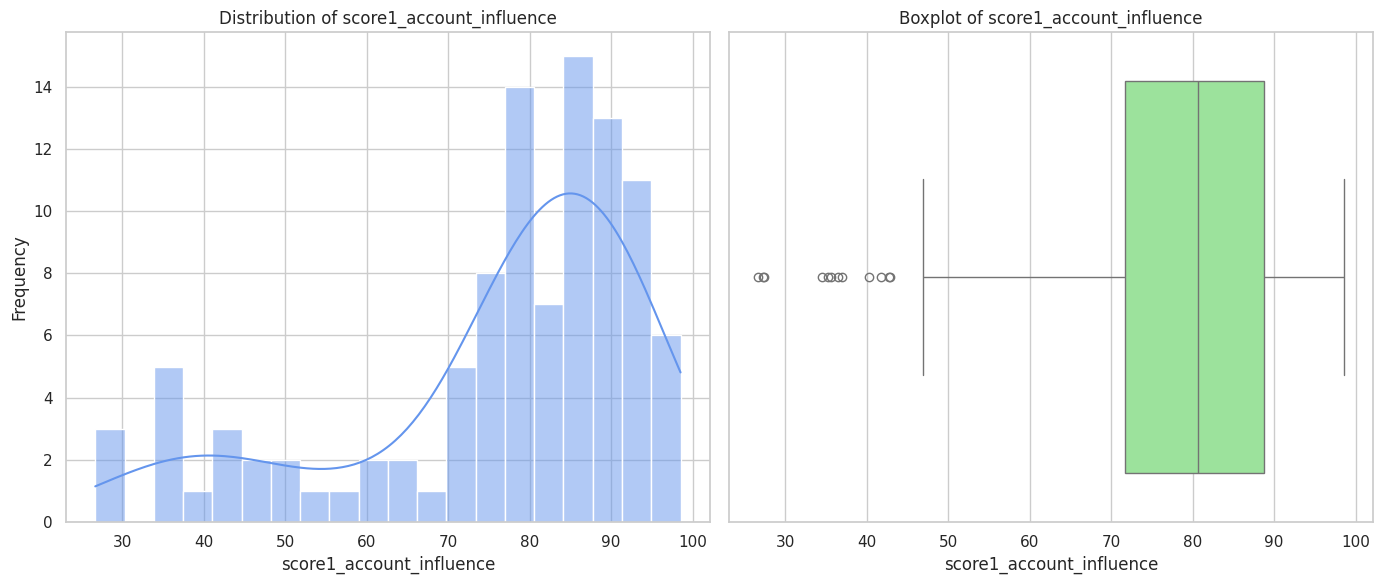

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visual style
sns.set(style='whitegrid')

# ==========================
# 1. Descriptive Statistics
# ==========================
stats = df_creator['score1_account_influence'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
print("Descriptive Statistics for 'score1_account_influence':\n")
print(stats)

# ==========================
# 2. Distribution Plots
# ==========================
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_creator['score1_account_influence'], bins=20, kde=True, color='cornflowerblue')
plt.title('Distribution of score1_account_influence')
plt.xlabel('score1_account_influence')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_creator['score1_account_influence'], color='lightgreen')
plt.title('Boxplot of score1_account_influence')
plt.xlabel('score1_account_influence')

# Display both plots
plt.tight_layout()
plt.show()


In [84]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/creator_cooked_xh.json'
df_creator.to_json(save_path, orient='records', force_ascii=False,date_format='iso',indent=4 )
import os
if os.path.exists(save_path):
    print(f"文件已成功保存至：{save_path}")
else:
    print("文件保存失败，请检查路径或挂载状态")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
文件已成功保存至：/content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/creator_cooked_xh.json
